In [1]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Converts `SavedModel` to TensorRT graph and measures inference time.

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time,os
tf_object_detection_dir = '../models/research/object_detection/'
os.sys.path.append(tf_object_detection_dir)
from absl import app
from absl import flags
import requests
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
# import tensorrt as trt
from tensorflow.python.saved_model import loader
from tensorflow.python.saved_model import tag_constants
from utils import label_map_util

from utils import visualization_utils as vis_util

import IPython.display as Disp
import numpy as np
import cv2

ModuleNotFoundError: No module named 'object_detection'

In [3]:
import sys

In [4]:
sys.executable

'/home/ubuntu/anaconda3/envs/tensorflow_p36/bin/python'

In [2]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.10
anaconda-client==1.6.14
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.7.1
astroid==1.6.3
astropy==3.0.2
attrs==18.1.0
Automat==0.3.0
autovizwidget==0.12.7
Babel==2.5.3
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.1.3
bokeh==1.0.4
boto==2.48.0
boto3==1.9.116
botocore==1.12.116
Bottleneck==1.2.1
cached-property==1.5.1
certifi==2019.3.9
cffi==1.11.5
characteristic==14.3.0
chardet==3.0.4
click==6.7
cloudpickle==0.5.3
clyent==1.2.2
colorama==0.3.9
contextlib2==0.5.5
cryptography==2.3.1
cycler==0.10.0
Cython==0.28.4
cytoolz==0.9.0.1
dask==0.17.5
datashape==0.5.4
decorator==4.3.0
defusedxml==0.5.0
distributed==1.21.8
docker==3.7.0
docker-compose==1.23.2
docker-pycreds==0.4.0
dockerpty==0.4.1
docopt==0.6.2
docutils==0.14
entrypoints==0.2.3
environment-kernels==1.1.1
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.4
Flask==1.0.2
Flask-Cors==3.0.4
gast==0.2.2
gevent==1

In [12]:

image_url = 'https://tensorflow.org/images/blogs/serving/cat.jpg'
saved_model_dir = 'faster_rcnn_resnet101_lowproposals_coco_2018_01_28/frozen_inference_graph.pb'
model_input = 'image_tensor:0'
model_output = ['detection_boxes:0',
               'detection_classes:0',
               'detection_scores:0',
               'num_detections:0']


#### loading original tensorflow model

In [13]:
def get_graph(frozen_model_file):
    with tf.gfile.GFile(frozen_model_file,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [14]:
# detection_graph = tf.Graph()
# with detection_graph.as_default():
#     od_graph_def = tf.GraphDef()
#     with tf.gfile.GFile(saved_model_dir, 'rb') as fid:
#         serialized_graph = fid.read()
#         od_graph_def.ParseFromString(serialized_graph)
#         tf.import_graph_def(od_graph_def, name='')

#### converting to tensorrt graph

In [15]:
# f = tf.gfile.GFile(saved_model_dir, 'rb')
# # define graph def object
# od_graph_def = tf.GraphDef()
# # store frozen graph from pb file
# od_graph_def.ParseFromString(f.read())

In [16]:
precision = "FP16"
batch_size=2
workspace_size=1 << 25
trt_graph = trt.create_inference_graph(get_graph(saved_model_dir),model_output,\
                                       precision_mode=precision,max_workspace_size_bytes=workspace_size,\
                                      max_batch_size=batch_size,is_dynamic_op=True)

with tf.gfile.GFile(saved_model_dir.replace('.pb','_trt.pb'),'wb') as f:
    f.write(trt_graph.SerializeToString())

In [17]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in get_graph(saved_model_dir).node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 11171
numb. of trt_engine_nodes in TensorRT graph: 0
numb. of all_nodes in TensorRT graph: 11172


In [8]:
# trt_detection_graph = tf.Graph()

# with trt_detection_graph.as_default():
#     od_graph_def = tf.GraphDef()
#     tf.import_graph_def(trt_graph,name='')

# #### saving tensorrt graph

# with trt_detection_graph.as_default():
#     with tf.Session(graph=trt_detection_graph) as sess:
#         tf.train.write_graph(sess.graph,
#                          'tensorrt_model_testing','tensorrt_model_ssd.pb', as_text=True)

#### normal graph

In [6]:
PATH_TO_LABELS = os.path.join(tf_object_detection_dir,'data', 'mscoco_label_map.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [7]:
video_url = '/home/prateek/Desktop/Video_Data/Video/5.In_front_of_engineering/Camera16_spandan office_spandan office_20181219102846_20181219102859_591291.mp4'
video_url = 0
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.8)
fps = []
graph = tf.Graph()  
num_inferences = 50
with graph.as_default():
    with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options) ) as sess:
#         # read TensorRT model
#         trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(get_graph(saved_model_dir), name='')
#         tf.import_graph_def(trt_graph, name='')
      # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
        if 'detection_masks' in tensor_dict:
            # The following processing is only for single image
            detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
            detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
            # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
            real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
            detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
            detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[0], image.shape[1])
            detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
            # Follow the convention by adding back the batch dimension
            tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)
        
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
        
        cap =  cv2.VideoCapture(video_url)
        while True:
            if cap.get(1)>num_inferences:
                break
            Disp.clear_output(wait=True)
            ret,image_np = cap.read()
            if not ret:
                break
            start_time = time.time()
            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image_np, 0)})
            current_fps = 1/(time.time()-start_time)
            fps.append(current_fps)
            print('FPS:' , current_fps)

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
            
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks'),
              use_normalized_coordinates=True,
              line_thickness=8)
            
            cv2.imshow('preview',image_np)
            k = cv2.waitKey(1)
            if k==27:
                cv2.destroyAllWindows()
                cap.release()
                break

FPS: 31.22132483754029


In [14]:
cap.release()

In [11]:
fps_1 = fps


In [14]:
import pandas as pd

In [15]:
%matplotlib inline

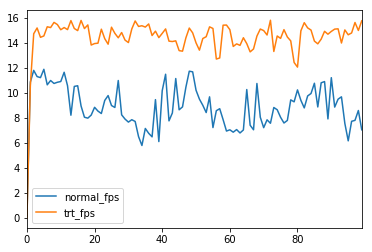

In [16]:
pd.DataFrame({'trt_fps':fps_1[:100],'normal_fps':fps[:100]}).plot()

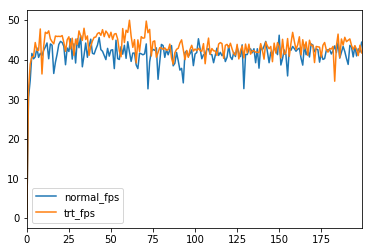

In [17]:
pd.DataFrame({'trt_fps':fps_1[:100],'normal_fps':fps[:100]}).plot()

In [7]:
cap = cv2.VideoCapture(0)
with trt_detection_graph.as_default():
    
    with tf.Session(graph=trt_detection_graph) as sess:
        while True:
            Disp.clear_output(wait=True)
            for i in range(1):
                ret,image  = cap.read()
            draw = image.copy()
            draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

            # process image
            start = time.time()
            op = sess.run(model_output,feed_dict={
                                model_input: [image]})

            #(boxes, scores, labels) = sess.run([boxes, scores,labels],feed_dict={image_tensor: image_np_expanded})
            print("FPS = ",1/(time.time()-start))
cap.release()

KeyboardInterrupt: 

In [11]:
cap.release()